# 1. Introduction

### *Table of Contents*

* 1.1 [Example: Polynomial Curve Fitting](#1.1-Example:-Polynomial-Curve-Fitting)
    * 2.1.1 [The Beta Distribution](#2.1.1-The-beta-distribution)
* 1.2 [Probability Theory](#1.2-Probability-Theory)
    * 1.2.1 [Probability densities](#1.2.1-Probability-densities)
    * 1.2.2 [Expectations and covariances](#1.2.2-Expectations-and-covariances)
    * 1.2.4 [The Gaussian distribution](#1.2.4-The-Gaussian-distribution)
    * 1.2.5 [Curve fitting re-visited](#1.2.5-Curve-fitting-re-visited)
* 1.6 [Information Theory](#1.6-Information-Theory)
    * 1.6.1 [Relative entropy and mutual information](#1.6.1-Relative-entropy-and-mutual-information)

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

from prml.feature.polynomial import PolynomialFeature
from prml.linear.linear_regression import LinearRegression
from prml.linear.ridge_regression import RidgeRegression
from prml.distribution import (
    Gaussian,
    MultivariateGaussian
)

# Set random seed to make deterministic
np.random.seed(0)

## 1.1. Example: Polynomial Curve Fitting

For presentation purposes, consider a synthetically generated example dataset. The data were generated from the function $\sin(2\pi x)$ by adding random Gaussian noise having standard deviation $\sigma=0.3$.

We generated $N{=}10$ observations spaced uniformly in range $[0,1]$. These observations comprise the input data vector,

$$
\mathsf{x} = (x_1,\dots,x_N)^\text{T}
$$

For each generated observation $x$ we obtained its corresponding value of the function $\sin(2\pi x)$ and then adding the random noise to capture the real-life situation of missing information.

$$
\mathsf{t} = (t_1,\dots,t_N)^\text{T}
$$

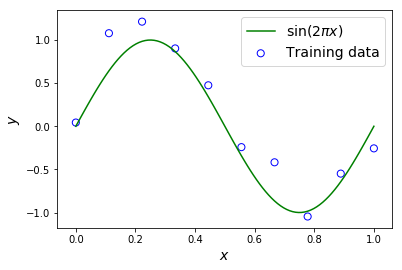

In [5]:
# Create data stemming from a given function f by adding gaussian noise
def generate_toy_data(f, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = f(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

# Sine function
def sin(x):
    return np.sin(2 * np.pi * x)

# Generate a train data set
x_train, y_train = generate_toy_data(sin, 10, 0.3)

# Generate a test data set
x_test = np.linspace(0, 1, 100)
y_test = sin(x_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Training data")
plt.plot(x_test, y_test, color="g", label="$\sin(2\pi x)$")
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(fontsize=14); plt.show()

The generated training dataset of $N{=}10$ points is shown as blue circles, each comprising an observation of the input variable $x$ along with the corresponding target variable $t$. The green curve shows the function $\sin(2\pi x)$ used to generate the data.

### Polynomial Linear Model

Our goal is to predict the value of $\hat{t}$ for some **new** value of $\hat{x}$, in the absence of any knowledge for the green curve. To that end, we consider a simple approach based on curve fitting. In particular, we shall try to fit the data using a polynomial function of the form

$$
y(x, \mathbf{w}) = w_0 + w_1x + w_2x^2 + \dots + w_Mx^M = \sum_{j=0}^M w_jx^j
$$

where $M$ is the *order* of the polynomial. Functions, such as $y(x, \mathbf{w})$, that are linear functions of the unknown coefficients $\mathbf{w}$, are called *linear models*.

### Error Function

Next, we need to determine the values of the coefficients $\mathbf{w}$ by fitting the polynomial to the training data. This can be done by minimizing an *error function* that measures the misfit between the function $y(x,\mathbf{w})$, for a given value of $\mathbf{w}$, and the training data points.

One simple error function is the *sum of squares of the errors* between $y(x,\mathbf{w})$ and the corresponding target values $t_n$

$$
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 \geq 0
$$

where the function becomes zero if, and only if, the function $y(x,\mathbf{w})$ were to pass
exactly through each training data point.

We can solve the curve fitting problem by choosing the value of $\mathbf{w}$ for which $E(\mathbf{w})$ is as small as possible. Because the error function is quadratic, its derivatives are linear, and so the minimization of the function has a unique closed from solution, denoted by $\mathbf{w}^*$. To minimize the error function we should derive the gradient vector, set it equal to zero and solve for $\mathbf{w}^*$

$$
\nabla E(\mathbf{w}^*) = \mathbf{0}
$$

To that end, first, we have to substitute the polynomial into the error function

$$
E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N (\sum_{j=0}^M w_jx_n^j - t_n)^2
$$

Note that each of the $N$ data points from the generated training set has $1$ dimension, that is $x \in \mathbb{R}$. However, the polynomial function populates $M$ features for each input $x$, essentially transforming $x$ into a $M$-dimensional vector. Thus, the training set $\mathsf{x}$ can be written as a $N\times M$ matrix $\mathbf{X}$ where $\mathbf{X}_{nj}$ represents $x_n^j$, that is, the $n$th input value raised in the power of $j$.

To find the gradient vector, we take the partial derivative of $E$ with respect to an arbitrary $w_k$. Differentiating the sum, term by term, we get

$$
\begin{align*}
\nabla E(\mathbf{w}^*)_k &= \frac{\partial}{\partial w_k} (\mathbf{w}) \\
&= \frac{1}{2}\sum_{n=1}^N 2 (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k
= \sum_{n=1}^N (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k \\
&= \sum_{n=1}^N (\mathbf{X}\mathbf{w} - \mathsf{t})_n\mathbf{X}_{nk}
= \sum_{n=1}^N \mathbf{X}_{kn}^\text{T}(\mathbf{X}\mathbf{w} - \mathsf{t})_n \\
&= \big(\mathbf{X}^\text{T}(\mathbf{X}\mathbf{w} - \mathsf{t})\big)_k
\end{align*}
$$

Using the partial derivative for one component, we compute the gradient vector by dropping the $k$ subscript. Thus, the minimizer $\mathbf{w}^*$ must satisfy

$$
\begin{equation*}
\nabla E(\mathbf{w}^*) = \mathbf{X}^\text{T}(\mathbf{X}\mathbf{w}^* - \mathsf{t}) = \mathbf{0}
\end{equation*}
$$

Solving for $\mathbf{w}^*$ gives the unique solution of the curve fitting problem

$$
\mathbf{X}^\text{T}(\mathbf{X}\mathbf{w}^* - \mathsf{t}) = \mathbf{0} \Leftrightarrow
\mathbf{X}^\text{T}\mathbf{X}\mathbf{w}^* = \mathbf{X}^\text{T}\mathsf{t} \Leftrightarrow
\mathbf{w}^* = (\mathbf{X}^\text{T}\mathbf{X})^{-1}\mathbf{X}^\text{T}\mathsf{t}
$$

The resulting polynomial is given by the function $y(x, \mathbf{w}^*)$.

### Model Selection

There remains the problem of choosing the order $M$ of the polynomial, which is an example of the important concept called *model selection*.

In order to study the effect of different $M$ values, we plot the result of fitting polynomials having orders $M{=}0,1,3,9$ to the data set.

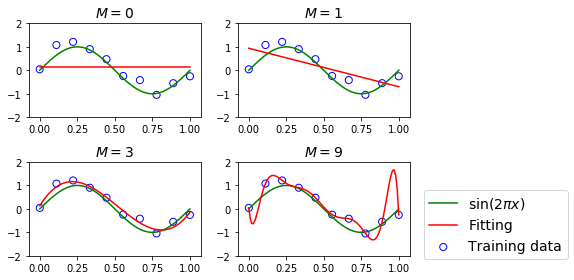

In [6]:
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    plt.tight_layout()
    
    feature = PolynomialFeature(degree)
    x_train_features = feature.transform(x_train)
    x_test_features = feature.transform(x_test)

    model = LinearRegression()
    model.fit(x_train_features, y_train)
    y = model.predict(x_test_features)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Training data")
    plt.plot(x_test, y_test, color="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, color="r", label="Fitting")
    plt.ylim(-2, 2)
    plt.title("$M={}$".format(degree), fontsize=14)

plt.legend(bbox_to_anchor=(1, 0.85), loc=2, borderaxespad=1, fontsize=14)
plt.show()

Note that the constant ($M{=}0$) and first order ($M{=}1$) polynomials give rather poor fits to the data. The third order ($M{=}3$) polynomial seems to give the best fit, while the higher order one ($M{=}9$) achieves an excellent fit to the data, that is, $E(\mathbf{w}^*){=}\mathbf{0}$. However, the fitted curve gives a poor representation of the underlying function $\sin(2\pi x)$. This phenomenon is known as *over-fitting*.

A more quantitative insight into the generalization performance on $M$ can be obtained by using the *root-mean-square* (RMS) error defined as

$$
E_{RMS} = \sqrt{2\frac{E(\mathbf{w}^*)}{N}}
$$

The RMS error on both training and test data points for each value of $M$ is shown in the following figure

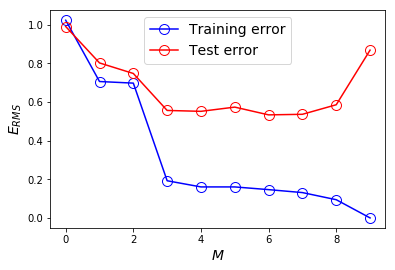

In [7]:
def rms_error(a, b):
    return np.sqrt(2 * np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(10):
    
    feature = PolynomialFeature(i)
    x_train_features = feature.transform(x_train)
    x_test_features = feature.transform(x_test)

    model = LinearRegression()
    model.fit(x_train_features, y_train)
    y = model.predict(x_test_features)
    training_errors.append(rms_error(model.predict(x_train_features), y_train))
    test_errors.append(rms_error(model.predict(x_test_features), y_test + np.random.normal(scale=0.3, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training error")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test error")
plt.xlabel("$M$", fontsize=14); plt.ylabel("$E_{RMS}$", fontsize=14)
plt.legend(fontsize=14); plt.show()

The test set error is measuring how well we are doing in predicting the values of $t$ for new data observations of $x$. For $M{=}9$, the training set error goes to zero, because the polynomial contains $10$ degrees of freedom and so it can be tuned exactly to the $10$ data points in the training set.

It is also interesting to examine the behavior of the model as the size of the data increases. The following figure depicts the result of fitting the $M{=}9$ polynomial for $N{=}15$ and $N{=}100$ data points.

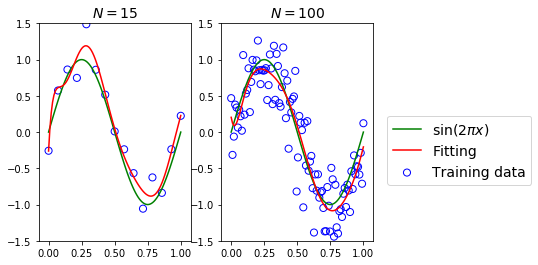

In [20]:
for i, size in enumerate([15, 100]):
    plt.subplot(1, 2, i + 1)

    # Generate a train set
    x_train_100, y_train_100 = generate_toy_data(sin, size, 0.3)

    # Generate a test set
    x_test_100 = np.linspace(0, 1, 100)
    y_test_100 = sin(x_test)

    feature = PolynomialFeature(9)
    x_train_100_features = feature.transform(x_train_100)
    x_test_100_features = feature.transform(x_test_100)

    model = LinearRegression()
    model.fit(x_train_100_features, y_train_100)
    y = model.predict(x_test_100_features)

    plt.scatter(x_train_100, y_train_100, facecolor="none", edgecolor="b", s=50, label="Training data")
    plt.plot(x_test_100, y_test_100, color="g", label="$\sin(2\pi x)$")
    plt.plot(x_test_100, y, color="r", label="Fitting")
    plt.ylim(-1.5, 1.5)
    plt.title("$N={}$".format(size), fontsize=14)

plt.legend(bbox_to_anchor=(1, 0.64), loc=2, borderaxespad=1, fontsize=14)
plt.show()

Note that the over-fitting problem becomes less severe as the size of the data set increases. In other words, the larger the data set, the more complex the model that we can afford to fit to the data.

### Regularization

One technique that is often used to control the over-fitting phenomenon is that of *regularization*, which adds a penalty term to the error function in order to discourage the coefficients from reaching large values. The simplest such penalty term is the sum of squares of all of the coefficients, leading to a modified error function of the following form

$$
\tilde{E}(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 + \lambda||\mathbf{w}||_2^2
$$

Such techniques are known as *shrinkage* methods because they reduce the value of the coefficients. The particular case of the quadratic regularization is called *ridge regression*. In neural networks, this approach is also known as *weight decay*.

Similar to the previous case, the ridge error function can be minimized exactly in closed form as follows

$$
\begin{align*}
\nabla E(\mathbf{w}^*)_k &= \frac{\partial}{\partial w_k} (\mathbf{w}) \\
&= \frac{1}{2}\sum_{n=1}^N 2 (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k + \frac{1}{2}\lambda 2w_k \\
&= \sum_{n=1}^N (\sum_{j=0}^M w_jx_n^j - t_n)x_n^k + \lambda w_k \\
&= \sum_{n=1}^N (\mathbf{X}\mathbf{w} - \mathsf{t})_n\mathbf{X}_{nk} + \lambda w_k
= \sum_{n=1}^N \mathbf{X}_{kn}^\text{T}(\mathbf{X}\mathbf{w} - \mathsf{t})_n + \lambda w_k \\
&= \big(\mathbf{X}^\text{T}(\mathbf{X}\mathbf{w} - \mathsf{t})\big)_k + \lambda w_k
\end{align*}
$$

Using the partial derivative for one component, we compute the gradient vector by dropping the $k$ subscript. Then, the minimizer $\mathbf{w}^*$ must satisfy

$$
\begin{equation*}
\nabla E(\mathbf{w}^*) =
\mathbf{X}^T(\mathbf{X}\mathbf{w}^* - \mathsf{t}) + \lambda\mathbf{w}^*\mathbf{I}= \mathbf{0}
\end{equation*}
$$

Solving for $\mathbf{w}^*$ gives the unique solution that minimizes the ridge error

$$
\begin{align*}
& \mathbf{X}^\text{T}(\mathbf{X}\mathbf{w}^* - \mathsf{t}) + \lambda\mathbf{w}^*\mathbf{I} = \mathbf{0} \Leftrightarrow \\
& \mathbf{X}^\text{T}\mathbf{X}\mathbf{w}^* - \mathbf{X}^\text{T}\mathsf{t} + \lambda\mathbf{w}^*\mathbf{I} = \mathbf{0} \Leftrightarrow \\
& \mathbf{X}^\text{T}\mathbf{X}\mathbf{w}^* + \lambda\mathbf{w}^*\mathbf{I} = \mathbf{X}^\text{T}\mathsf{t} \Leftrightarrow \\
& \mathbf{w}^*(\mathbf{X}^\text{T}\mathbf{X} + \lambda\mathbf{I}) = \mathbf{X}^\text{T}\mathsf{t} \Leftrightarrow \\
& \mathbf{w}^* = (\mathbf{X}^\text{T}\mathbf{X} + \lambda\mathbf{I})^{-1}\mathbf{X}^\text{T}\mathsf{t}
\end{align*}
$$

The following figures depict the results of fitting the polynomial of order $M{=}9$ to the same data set as before but now using the regularized error function. We see that, for a value of $\ln\lambda{=}−18$, the over-fitting has been suppressed and we now obtain a much closer representation of the underlying function $\sin(2\pi x)$. If, however, we use too large a value for $\lambda$ then we again obtain a poor fit.

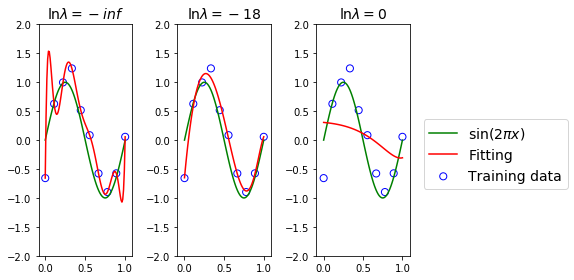

In [36]:
feature = PolynomialFeature(9)
x_train_features = feature.transform(x_train)
x_test_features = feature.transform(x_test)

for i, ln_lambda in enumerate([float('-inf'), -18, 0]):
    plt.subplot(1, 3, i + 1)
    plt.tight_layout()

    model = RidgeRegression(alpha=math.exp(ln_lambda))
    model.fit(x_train_features, y_train)
    y = model.predict(x_test_features)

    plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="Training data")
    plt.plot(x_test, y_test, color="g", label="$\sin(2\pi x)$")
    plt.plot(x_test, y, color="r", label="Fitting")
    plt.ylim(-2, 2)
    plt.title("$\ln\lambda={}$".format(ln_lambda), fontsize=14)

plt.legend(bbox_to_anchor=(1, 0.65), loc=2, borderaxespad=1, fontsize=14)
plt.show()

A sample of coefficients from the fitted polynomials is presented in the table below, showing that regularization has the desired effect of reducing the magnitude of the coefficients.

| $\ln\lambda{=}-\infty$ | $\ln\lambda{=}-18$ | $\ln\lambda{=}0$ |
|-----------------------:|-------------------:|-----------------:|
| $0.39$                 | $0.38$             | $0.36$           |
| $-135.04$              | $-2.14$            | $-0.46$          |
| $3206.76$              | $81,88$            | $-0.39$          |
| $-29215.92$            | $-390.51$          | $-0.22$          |
| $139594.34$            | $578.12$           | $-0.05$          |
| $-388863.80$           | $-31.48$           | $0.07$           |
| $652373.24$            | $-49.12$           | $0.17$           |
| $-648124.69$           | $-28.57$           | $0.25$           |
| $350721.94$            | $540.17$           | $0.31$           |
| $-79556.29$            | $-255.65$          | $0.35$           |

The impact of the regularization term on the generalization error can be seen by plotting the value of the RMS error for both training and test sets against $\ln\lambda$, as shown in the figure. We see that in effect $\lambda$ controls the effective complexity of the model and hence determines the degree of over-fitting.

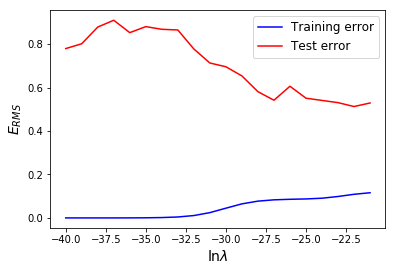

In [8]:
training_errors = []
test_errors = []

feature = PolynomialFeature(9)
x_train_features = feature.transform(x_train)
x_test_features = feature.transform(x_test)

ln_lambda_values = range(-40, -20, 1)
for ln_lambda in ln_lambda_values:

    model = RidgeRegression(alpha=math.exp(ln_lambda))
    model.fit(x_train_features, y_train)
    training_errors.append(rms_error(model.predict(x_train_features), y_train))
    test_errors.append(rms_error(model.predict(x_test_features), y_test + np.random.normal(scale=0.3, size=len(y_test))))

plt.plot(ln_lambda_values, training_errors, mfc="none", mec="b", ms=10, c="b", label="Training error")
plt.plot(ln_lambda_values, test_errors, mfc="none", mec="r", ms=10, c="r", label="Test error")
plt.xlabel("$\ln\lambda$", fontsize=14); plt.ylabel("$E_{RMS}$", fontsize=14)
plt.legend(fontsize=12); plt.show()

# 1.2 [Probability Theory](https://seeing-theory.brown.edu)

The probability $p(A)$ of an event $A$ is always a non-negative number, i.e.,

$$
p(A) \geq 0
$$

The probability $p(B)$ of an event $B$ which is certain to occur is always equal to one, i.e.,

$$
p(B) = 1
$$

In case two events $A$ and $B$ are **mutually exclusive**, that is, they cannot occur simultaneously $p(A \cap B)=0$, then the probability of occurrence of either $A$ or $B$ is denoted as $A \cup B$ and is given by

$$
p(A \cup B) = p(A) + p(B) - 2p(A \cap B) = p(A) + p(B)
$$

![Venn](../images/venn.png)

### Rules of Probability

Consider the slightly more general example involving two random variables $X$ and $Y$ instead of just two events (which are essentially binary random variables). Suppose that $X$ can take any of the values $x_i$, and $Y$ can take the values $y_j$. Moreover, consider a total of $N$ trials, and let the number of such trials in which $X=x_i$ and $Y=y_j$ be $n_{ij}$. Also, let the number of trials in which $X$ takes the value $x_i$ (irrespective of the value that $Y$ takes) be denoted by $c_i$, and similarly let the number of trials in which $Y$ takes the value $y_j$ be denoted by $r_j$.

<img src="../images/fg1_10.png" width="400"/>

Then the **marginal**, **conditional** and **joint probabilities** are given by

$$
p(X=x_i)=\frac{c_i}{N}\quad
p(Y=y_j)=\frac{r_j}{N}\quad
p(X=x_i,Y=y_j)=\frac{n_{ij}}{N}\quad
p(Y=y_j|X=x_i)=\frac{r_j}{c_i}
$$

Note that the joint probability $p(X=x_i,Y=y_j)$ is short notation for $p(X=x_i \cap Y=y_j)$.

#### Sum rule:

$$
p(X) = \sum_Y p(X,Y) = \int_Y p(X,Y) dY
$$

Applying the sum rule as above is called "marginalizing out $Y$".

#### Product rule:

$$
p(X,Y) = p(Y|X)p(X)
$$

Computing $p(Y|X)$ is called "conditioning on $X$". The product rule is generalized as follows

$$
p(X_1,X_2,\dots,X_K) = p(X_K|X_{K-1},\dots,X_1)p(X_{K-1},\dots,X_1),\dots
$$

Note that if the *joint distribution* of two random variables factorizes into the product of their marginals, so that $p(X,Y) = p(X)p(Y)$, then $X$ and $Y$ are said to be *statistically independent*. In such case, the product rule becomes $p(Y|X) = p(Y)$.

### Bayes Theorem

From the *product rule*, we can immediately obtain the [*Bayes' theorem*](https://www.youtube.com/watch?v=HZGCoVF3YvM), using the symmetry property $p(X, Y) = p(Y, X)$ as follows

$$
\begin{align*}
& p(X,Y) = p(Y|X)p(X) \Leftrightarrow \\
& p(Y|X) = \frac{p(X, Y)}{p(X)} \Leftrightarrow \\
& p(Y|X) = \frac{p(Y, X)}{p(X)} \Leftrightarrow \\
& p(Y|X) = \frac{p(X|Y)p(Y)}{p(X)}
\end{align*}
$$

Using the *sum* and *product rules*, the marginal probability $p(X)$ in the denominator can be expressed in terms of the quantities in the numerator

$$
\begin{equation*}
p(Y|X) = \frac{p(X|Y)p(Y)}{\sum_Y p(X,Y)} = \frac{p(X|Y)p(Y)}{\sum_Y p(X|Y)p(Y)}
\end{equation*}
$$

An interpretation of the Bayes theorem is that if we had been asked which is the most probable value of $Y$, *before* we observe any value for $X$, then the most complete information we have available is provided by the
*prior probability* $p(Y)$. *After* we observe the value of $X$, we can use the Bayes theorem to compute the the *posterior* probability $p(Y|X)$, which represents our updated knowledge after incorporating the evidence provided by the observed data.

Let $\mathbf{w}$ be parameters and $\mathcal{D}$ be data. Bayes theorem is given by

$$
\begin{equation*}
p(\mathbf{w}|\mathcal{D}) =
\frac{p(\mathcal{D}|\mathbf{w})p(\mathbf{w})}{p(\mathcal{D})}
\Leftrightarrow
\mathrm{posterior} =
\frac{\mathrm{likelihood}\, \times\, \mathrm{prior}}{\mathrm{evidence}}
\end{equation*}
$$

The frequentist paradigm generally quantifies the properties of data driven quantities in the light of the fixed model parameters, while the Bayesian paradigm generally quantifies the properties of unknown model parameters in light of observed data.

![Benjamin Bannekat](../images/frequentists_vs_bayesians.png)

## 1.2.1 Probability densities

<img src="../images/fg1_12.png" width="400"/>

If the probability of a real-valued variable $x$ falling in the interval $(u, u + \delta)$ is given by $p_x(u)\delta$, then $p_x(x)$ is called the probability density function over $x$. 

$$
\begin{align*}
p(u \leq x \leq u + \delta) =  \int_{u}^{u + \delta} p(x)dx = 
P_x(u + \delta) - P_x(u) = 
\frac{P_x(u + \delta) - P_x(u)}{\delta} \delta
\end{align*}
$$

Then we have that

$$
\lim_{\delta\to 0} \frac{P_x(u + \delta) - P_x(u)}{\delta} \delta = \frac{dP_x(u)}{dx}\delta = p_x(x)\delta
$$

Therefore, the probability that $x$ will lie in an interval $(a, b)$ is then given by

$$
\begin{equation*}
p(a \leq x \leq b) = \int_a^b p_x(x)dx
\end{equation*}
$$

and it must satisfy the following two conditions

$$
\begin{align*}
& p_x(x) \geq 0 \\
\int_{-\infty}^\infty & p_x(x)dx = 1
\end{align*}
$$

The probability that $x$ lies in the interval $(−\infty, z)$ is given by the *cumulative distribution function* (CDF) given by

$$
\begin{equation*}
P_x(z) = \int_{-\infty}^z p_x(x)dx
\end{equation*}
$$

where

$$
p(x) = \frac{dP_x(x)}{dx}
$$

If $x$ is a discrete variable, then $p_x(x)$ is sometimes called a *probability mass function* (PMF) because it can be regarded as a set of *probability masses* concentrated at the allowed values of $x$.


## 1.2.2 Expectations and covariances

The average value of some function $f(x)$ under a probability distribution $p_x(x)$ is called the *expectation* of $f(x)$ and is denoted by $\mathbb{E}[f]$. The average is weighted by the relative probabilities of the different values of $x$ as follows

$$
\begin{equation*}
\mathbb{E}[f] = \sum_x p_x(x)f(x) = \int p_x(x)f(x)dx
\end{equation*}
$$

For a finite number of $N$ points drawn from the probability distribution, then the expectation can be approximated as a finite sum over these points

$$
\begin{equation*}
\mathbb{E}[f] \approx \frac{1}{N} \sum_{n=1}^N f(x_n)
\end{equation*}
$$

Note that the expectations of functions of several variables, may use a subscript to indicate which variable is being averaged, i.e., $\mathbb{E}_x[f(x,y)]$.

Whereas the expectation provides a measure of centrality, the variance of a random variable quantifies the spread of that random variable's distribution. Thus, the variance provides a measure of how much variability there is in $f(x)$ around its mean value $\mathbb{E}[f(x)]$ and is defined as follows

$$
\begin{align*}
\mathrm{var}[f] &= \mathbb{E}[(f(x) − \mathbb{E}[f(x)])^2] \\
&= \mathbb{E}[f(x)^2 − 2f(x)\mathbb{E}[f(x)] + \mathbb{E}[f(x)]^2] \\
&= \mathbb{E}[f(x)^2] − \mathbb{E}[2f(x)\mathbb{E}[f(x)]] + \mathbb{E}[\mathbb{E}[f(x)]^2] \\
&= \mathbb{E}[f(x)^2] − 2\mathbb{E}[f(x)]\mathbb{E}[f(x)] + \mathbb{E}[f(x)]^2 \\
&= \mathbb{E}[f(x)^2] − \mathbb{E}[f(x)]^2
\end{align*}
$$

The covariance expresses the extent to which $x$ and $y$ vary together and is given by

$$
\begin{equation*}
\mathrm{cov}[x, y] = \mathbb{E}_{x,y}[(x − \mathbb{E}[x])(y − \mathbb{E}[y])] =
\mathbb{E}_{x,y}[xy] − \mathbb{E}[x]\mathbb{E}[y]
\end{equation*}
$$

A covariance matrix $\mathbf{\Sigma}$ has entries $\sigma_{ij}$ corresponding to the covariance of variables $i$ and $j$. If two variables are independent, then their covariance vanishes, e.g., $\mathbf{\Sigma} = \mathbf{I}$.


## 1.2.4 The Gaussian distribution

The *Normal* or *Gaussian* distribution is one of the most important probability distributions for continuous variables. For the case of a single real-valued variable $x$, the distribution is defined as follows

$$
\begin{equation}
\mathcal{N}(x|\mu,\sigma^2) =
\frac{1}{(2\pi\sigma^2)^{1/2}}\exp\Big\{-\frac{1}{2\sigma^2}(x-\mu)^2\Big\}
\end{equation}
$$

and is governed by the parameters $\mu$, called the *mean*, and $\sigma^2$, called the *variance*. The square root of the variance $\sigma$ is called *standard deviation*. An alternative way to represent a Gaussian distribution is by considering a *precision* term $\beta = \frac{1}{\sigma^2}$, denoted by

$$
\mathcal{N}(x|\mu,\beta^{-1}) =
\frac{\beta^{1/2}}{\sqrt{2\pi\sigma^2}}\exp\Big\{-\frac{\beta}{2}(x - \mu)^2 \Big\}
$$

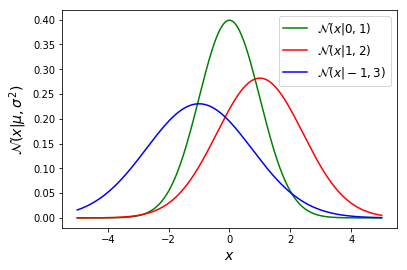

In [41]:
x_space = np.linspace(-5, 5, 1000)

for mean, var, c in [(0, 1, "g"), (1, 2, "r"), (-1, 3, "b")]:
    
    N_distribution = Gaussian(mean, var)
    y = [N_distribution.pdf(x) for x in x_space]
    
    plt.plot(x_space, y, color=c, label="$\mathcal{N}$" + "$(x|{},{})$".format(mean, var))

plt.xlabel("$x$", fontsize=14); plt.ylabel("$\mathcal{N}(x|\mu,\sigma^2)$", fontsize=14)
plt.legend(fontsize=12); plt.show()

Note that the probability density function is *not an actual probability*, therefore it can take values $\mathcal{N}(x|\mu,\sigma^2) > 1$. We can see that the Gaussian distribution satisfies

$$
\begin{align*}
& \mathcal{N}(x|\mu,\sigma^2) > 0 \\
\int & \mathcal{N}(x|\mu,\sigma^2)dx = 1
\end{align*}
$$

The Gaussian distribution can be also defined over a $D$-dimensional vector $\mathbf{x}$ if continuous variables as follows:

$$
\begin{equation}
\mathcal{N}(\mathbf{x}|\mathbf{\mu},\mathbf{\Sigma}) =
\frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}}
\exp\Big\{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu})^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}-\mathbf{\mu})\Big\}
\end{equation}
$$

where the $D$-dimentional vector $\mathbf{\mu}$ holds the mean of each dimension, while the $D\times D$ matrix $\mathbf{\Sigma}$ is the covariance.

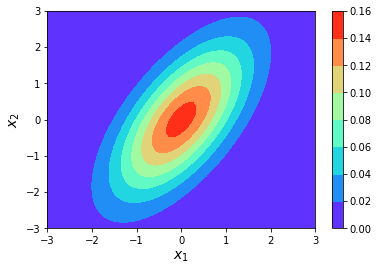

In [51]:
mean = np.array([0, 0])
sigma = np.array(
    [[1.0, 0.92],
     [0.92, 2.0]]
)

N_distribution = MultivariateGaussian(mean, sigma)

N = 100
x1, x2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
p = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        p[i, j] = N_distribution.pdf(np.array([x1[i, j], x2[i, j]]))

cp = plt.contourf(x1, x2, p, cmap='rainbow')
plt.colorbar(cp)
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.axis([-3, 3, -3, 3])
plt.show()

### Maximum likelihood

Consider we have a data set of observations $\mathsf{x}=(x_1,\dots,x_N)^\text{T}$ drawn independently from a Gaussian distribution. Data points that are drawn independently from the same distribution are said to be *independent and identically distributed*.

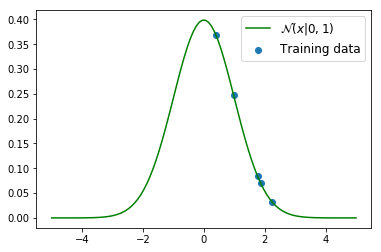

In [17]:
N_distribution = Gaussian(0, 1)
x_sample_data = N_distribution.draw(5)
y_sample_data = [N_distribution.pdf(x) for x in x_sample_data]

x_space = np.linspace(-5, 5, 100)
y = [N_distribution.pdf(x) for x in x_space]

plt.scatter(x_sample_data, y_sample_data, label="Training data")
plt.plot(x_space, y, color="g", label="$\mathcal{N}(x|0,1)$")
plt.legend(fontsize=12); plt.show()

Because the data are independent, the likelihood function is as follows

$$
p(\mathsf{x}|\mu,\sigma^2) = \prod_{n=1}^N \mathcal{N}(x_n|\mu, \sigma^2)
$$

which corresponds to the product of the blue points in the figure above. Therefore, in order to find the unknown parameters $\mu$ and $\sigma^2$ is to use the observed data set and find the parameter values that maximize the likelihood function.

The log likelihood function can be written as follows

$$
\begin{align*}
\ln p(\mathsf{x}|\mu,\sigma^2) &= \ln \Bigg[ \prod_{n=1}^N \mathcal{N}(x_n|\mu, \sigma^2) \Bigg] \\
&= \sum_{n=1}^N \ln\mathcal{N}(x_n|\mu, \sigma^2) \\
&\overset{(1.46)}= \sum_{n=1}^N \ln \bigg(
\frac{1}{(2\pi\sigma^2)^{1/2}}\exp\Big\{-\frac{1}{2\sigma^2}(x_n-\mu)^2\Big\} \bigg) \\
&= \sum_{n=1}^N \ln \bigg( \frac{1}{(2\pi\sigma^2)^{1/2}} \bigg) +
\sum_{n=1}^N \ln \bigg(\exp\Big\{-\frac{1}{2\sigma^2}(x_n-\mu)^2\Big\} \bigg) \\
&= N\ln \bigg( \frac{1}{(2\pi\sigma^2)^{1/2}} \bigg) -
\sum_{n=1}^N \frac{1}{2\sigma^2}(x_n-\mu)^2 \\
&= N\ln1 - N\ln (2\pi\sigma^2)^{1/2} - \frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \\
&\overset{\ln1=0}= -N\ln (2\pi\sigma^2)^{1/2} - \frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \\
&\overset{\ln x^y=y\ln x}= -\frac{N}{2}\ln 2\pi\sigma^2 - \frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \\
&= -\frac{N}{2}\ln 2\pi -\frac{N}{2}\ln\sigma^2 - \frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \\
\end{align*}
$$

Then by maximizing with respect to $\mu$, we obtain the following solution

$$
\begin{align*}
& \frac{\partial \ln p(\mathsf{x}|\mu,\sigma^2)}{\partial \mu} = 0 \Leftrightarrow \\
& \frac{\partial}{\partial \mu}
\bigg( \frac{N}{2}\ln 2\pi -\frac{N}{2}\ln\sigma^2 - \frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \bigg) = 0
\Leftrightarrow \\
& \frac{\partial}{\partial \mu} \bigg( \frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \bigg) = 0 \Leftrightarrow \\
& \frac{\partial}{\partial \mu} \sum_{n=1}^N (x_n-\mu)^2 = 0 \Leftrightarrow \\
& \sum_{n=1}^N (2\mu - 2x_n) = 0 \Leftrightarrow 2\sum_{n=1}^N (\mu - x_n) = 0 \Leftrightarrow \\
& N\mu - \sum_{n=1}^N x_n = 0 \Leftrightarrow N\mu = \sum_{n=1}^N x_n \Leftrightarrow \\
& \mu_{ML} = \frac{1}{N}\sum_{n=1}^N x_n
\end{align*}
$$

which is the *sample mean* of the observed values $\mathsf{x}$. In a similar manner, maximizing with respect to $\sigma^2$, we obtain the maximum likelihood solution for the variance as follows

$$
\begin{align*}
& \frac{\partial \ln p(\mathsf{x}|\mu,\sigma^2)}{\partial \sigma^2} = 0 \Leftrightarrow \\
& \frac{\partial}{\partial \sigma^2}
\bigg( \frac{N}{2}\ln 2\pi -\frac{N}{2}\ln\sigma^2 - \frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \bigg) = 0
\Leftrightarrow \\
& \frac{\partial}{\partial \sigma^2}
\bigg( -\frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 - \frac{N}{2}\ln\sigma^2 \bigg) = 0
\Leftrightarrow \\
& \frac{\partial}{\partial \sigma^2} \bigg(-\frac{1}{2\sigma^2} \sum_{n=1}^N (x_n-\mu)^2 \bigg) +
\frac{\partial}{\partial \sigma^2} \bigg(-\frac{N}{2}\ln\sigma^2 \bigg) = 0
\Leftrightarrow \\
& \frac{\partial}{\partial \sigma^2} \bigg(-(2\sigma^2)^{-1} \sum_{n=1}^N (x_n-\mu)^2 \bigg) +
- \frac{N}{2\sigma^2} = 0
\Leftrightarrow \\
& \frac{1}{4\sigma^4} \sum_{n=1}^N (x_n-\mu)^2 - \frac{N}{2\sigma^2} = 0
\Leftrightarrow \\
& \frac{1}{4\sigma^4} \sum_{n=1}^N (x_n-\mu)^2 = \frac{N}{2\sigma^2}
\Leftrightarrow \\
& \sigma_{ML}^2 = \frac{1}{N} \sum_{n=1}^N (x_n-\mu_{ML})^2
\end{align*}
$$

which is the *sample variance* measured with respect to the sample mean $\mu_{ML}$.

**TODO: Prove the bias in the variance parameter**

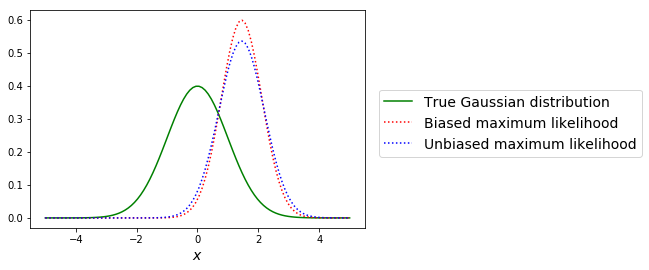

In [18]:
N_distribution.ml(x_sample_data, unbiased=False)
y_biased = [N_distribution.pdf(x) for x in x_space]
N_distribution.ml(x_sample_data, unbiased=True)
y_unbiased = [N_distribution.pdf(x) for x in x_space]

plt.plot(x_space, y, color="g", label="True Gaussian distribution")
plt.plot(x_space, y_biased, color="r", ls=":", label="Biased maximum likelihood")
plt.plot(x_space, y_unbiased, color="b", ls=":", label="Unbiased maximum likelihood")
plt.xlabel("$x$", fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=1, fontsize=14); plt.show()

### 1.2.5 Curve fitting re-visited

We shall assume that, the target variable $t$ has a Gaussian distribution with mean equal to $y(x,\mathbf{w})$ of the polynomial curve, as follows

$$
p(t|x,\mathbf{w},\beta) = \mathcal{N}(t|y(x,\mathbf{w}),\beta)
$$

Then, we can use the training data $\mathsf{x,t}$ to determine the values of the unknown parameters $\mathbf{w},\beta$ by maximum likelihood. Assuming the data are i.i.d, the likelihood function is given by

$$
p(\mathsf{t}|\mathsf{x},\mathbf{w},\beta) = \prod_{n=1}^N \mathcal{N}(t_n|y(x,\mathbf{w}),\beta^{-1})
$$

Similar to the Gaussian distribution earlier, we maximize the logarithm of the likelihood function in the form

$$
\ln p(\mathsf{t}|\mathsf{x},\mathbf{w},\beta) =
-\frac{\beta}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 +
\frac{N}{2}\ln\beta - \frac{N}{2}\ln2\pi
$$

For determining the maximum likelihood solution for the polynomial coefficients $\mathbf{w}_{ML}$, we can omit the terms that do not depend on $\mathbf{w}$. Moreover, since the $\beta$ does not alter the location of the function it can be replaced by $1$. Therefore the maximization is equivalent to minimizing the *sum of squares error function*, as presented [above](#Error-Function).

Therefore the sum of squares error function has arisen as a consequence of maximizing the likelihood under the assumption of a Gaussian noise distribution.

As a final step, we can also use maximum likelihood to determine the precision parameter $\beta$, as follows:

$$
\begin{align*}
& \frac{\partial}{\partial\beta} \ln p(\mathsf{t}|\mathsf{x},\mathbf{w},\beta) = 0 \Leftrightarrow \\
& \frac{\partial}{\partial\beta}
\Big [
-\frac{\beta}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 + \frac{N}{2}\ln\beta - \frac{N}{2}\ln2\pi
\Big ] = 0
\Leftrightarrow \\
& \frac{\partial}{\partial\beta}
\Big [
-\frac{\beta}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2
\Big ] +
\frac{\partial}{\partial\beta}
\Big [
\frac{N}{2}\ln\beta
\Big ] = 0
\Leftrightarrow \\
& -\frac{1}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 + \frac{N}{2}\frac{1}{\beta} = 0
\Leftrightarrow \\
& \sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 = \frac{N}{\beta}
\Leftrightarrow \\
& \frac{1}{\beta_{ML}} = \frac{1}{N}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2
\end{align*}
$$

Since we have a probabilistc model, we can use the predictive distribution that gives the probability distribution over $t$, rather than a simple point estimate. Thus,

$$
p(t|x,\mathbf{w}_{ML},\beta_{ML}) = \mathcal{N}(t|y(x,\mathbf{w}_{ML}),\beta_{ML}^{-1})
$$

We can further introduce a prior distribution over the polynomial coefficients $\mathbf{w}$, in order to take a step towards a more Bayesian approach. Consider for instance a Gaussian prior of the form,

$$
p(\mathbf{w}|\alpha) = \mathcal{N}(\mathbf{w}|\mathbf{0},\alpha^{-1}\mathbf{I}) = \Big(\frac{\alpha}{2\pi}^{(M+1)/2}\Big)\exp\Big\{-\frac{\alpha}{2}\mathbf{w}^{\text{T}}\mathbf{w}\Big\}
$$

where $\alpha$ is the precision of the multivariate Gaussian, and $M$ is the order of the polynomial, that is, the dimension of the paremeter vector $\mathbf{w}$. Then from the Bayes theorem we have that,

$$
p(\mathbf{w}|\mathsf{x},\mathsf{t},\alpha,\beta) \propto p(\mathsf{t}|\mathsf{x},\mathbf{w},\beta) p(\mathbf{w}|\alpha)
$$

Therefore, we can determine $\mathbf{w}$, by maximizing the posterior distribution. This technique is known as *maximum posterior* or MAP inference. The maximum of the posterior is given by the minimum of the negative logarithm, which it can be proved to be

$$
\frac{\beta}{2}\sum_{n=1}^N (y(x,\mathbf{w}) - t_n)^2 + \frac{\alpha}{2}\mathbf{w}^{\text{T}}\mathbf{w}
$$

Thus we see that maximizing the posterior distribution is equivalent to minimizing the regularized sum of squared error function encountered in [Regularization](#Regularization), where $\lambda=\alpha/\beta$.

# 1.6 Information Theory

*How much information is received when we observe a specific variable?*

Consider for instance the event of seeing an alien spaceship appearing in the sky. We have never seen one and we would be extremely surprised if one day such an event occured, since it is unexpected given our current knowledge. Therefore, the amount of information can be viewed as the *degree of surprise* on learning the value of $x$. The measure of information content is therefore depend on the probability distribution $p(x)$ and in particular is given by the logarithm of $p(x)$ as follows,

$$
\text{h}(x)=-\log_2p(x)
$$

where the negative sign ensures that $h(x) \geq 0$. When the base of the logarithm is $2$ the units of $h(x)$ are **bits**.

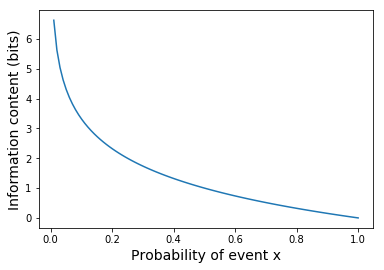

In [68]:
def h(prob: float):
    assert 0 <= prob <= 1, "probability should be [0,1]" 
    if prob == 0:
        return float('-inf')
    else:
        return -math.log2(prob)

px_space = np.linspace(0, 1, 100)
y = [h(px) for px in px_space]

plt.plot(px_space, y)
plt.xlabel("Probability of event x", fontsize=14); plt.ylabel("Information content (bits)", fontsize=14)
plt.show()

The average amount of information is obtained by taking the expectation over the information content, given by,

$$
\text{H}[x] = -\sum_{x} p(x)h(x) = -\sum_{x} p(x)\log_2 p(x)
$$

This important quantity is called *entropy* of the random variable $X$. Consider a discrete random variable $X$ having two possible values $x_1$ and $x_2$ with probabilities $p$ and $1-p$.

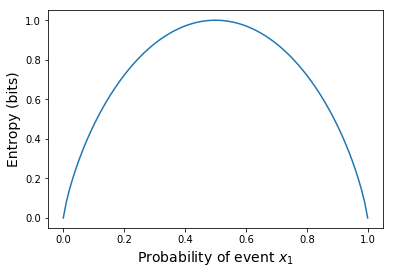

In [69]:
def entropy(probs):
    if 0 in probs:
        return 0
    else:
        return sum([px * h(px) for px in probs])

px_space = np.linspace(0, 1, 100)
y = [entropy([px, 1-px]) for px in px_space]

plt.plot(px_space, y)
plt.xlabel("Probability of event $x_1$", fontsize=14); plt.ylabel("Entropy (bits)", fontsize=14)
plt.show()

Note that the entropy is maximized when the two events are equiprobable, that is, for uniform distributions. The entory is also defined in a similar way for continous random variables and is called *differential entropy*:

$$
\text{H}[\mathbf{x}] = -\int p(\mathbf{x}) \ln p(\mathbf{x})\text{d}\mathbf{x}
$$

In the case of a joint distribution $p(\mathbf{x},\mathbf{y})$, the average additional information needed to specify $\mathbf{y}$ given that the value of $\mathbf{x}$ is already known, is called *conditional entropy*, and is given by

$$
\text{H}[\mathbf{y}|\mathbf{x}] = 
-\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{y}|\mathbf{x})\text{d}\mathbf{x}\text{d}\mathbf{y}
$$

Moreover it is easily seen, using the product rule, that the conditional entropy satisfies the relation,

$$
\begin{align*}
\text{H}[\mathbf{x},\mathbf{y}] &= 
-\int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{x},\mathbf{y})\text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \ln \big(p(\mathbf{y}|\mathbf{x})p(\mathbf{x})\big)\text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \big(\ln p(\mathbf{y}|\mathbf{x}) + \ln p(\mathbf{x})\big) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{y}|\mathbf{x}) \text{d}\mathbf{x}\text{d}\mathbf{y}
-\int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{x}) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{y}|\mathbf{x}) \text{d}\mathbf{x}\text{d}\mathbf{y}
-\int\int p(\mathbf{x},\mathbf{y})\text{d}\mathbf{y} \ln p(\mathbf{x}) \text{d}\mathbf{x} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{y}|\mathbf{x}) \text{d}\mathbf{x}\text{d}\mathbf{y}
-\int p(\mathbf{x}) \ln p(\mathbf{x}) \text{d}\mathbf{x} \\
&= \text{H}[\mathbf{y}|\mathbf{x}] + \text{H}[\mathbf{x}]
\end{align*}
$$

stating that the information needed to describe $\mathbf{x}$ and $\mathbf{y}$ is given by the information needed to describe $\mathbf{x}$ alone plus the additional information to specify $\mathbf{y}$.

## 1.6.1 Relative entropy and mutual information

Consider some unknown distribution $p(\mathbf{x})$ that we have modelled using an approximate distribution $q(\mathbf{x})$. Then, the average *additional* information required to specify a value of $\mathbf{x}$ as a result of using $q(\mathbf{x})$ instead of $p(\mathbf{x})$ is given by

$$
\text{KL}(p||q) = 
-\int p(\mathbf{x})\ln q(\mathbf{x})d\mathbf{x} 
-\bigg( -\int p(\mathbf{x}) \ln q(\mathbf{x})d\mathbf{x} \bigg) =
-\int p(\mathbf{x}) \big( \ln q(\mathbf{x}) - \ln p(\mathbf{x}) \big) d\mathbf{x} = 
-\int p(\mathbf{x}) \ln\big( \frac{q(\mathbf{x})}{p(\mathbf{x})} \big) d\mathbf{x}.
$$

This is known as the *relative entropy* or *Kullback-Leibler divergence* between distributions $p(\mathbf{x})$ and $q(\mathbf{x})$. Note that it is not a symmetrical quantity, that is to say $\text{KL}(p||q) \neq \text{KL}(q||p)$. Moreover the Kullback-Leibler divergence satisfies $\text{KL}(p||q) \geq 0$, where the equality holds if, and only if, $p(\mathbf{x}) = q(\mathbf{x})$. Thus, we can interpret the Kullback-Leibler divergence as a measure of dissimilarity of the two distributions.

Since the most efficient compression is achieved when we know the true distribution, otherwise additional information is required, there is an important relationship between data compression and density estimation.

Suppose we are trying to approximate the unknown distribution using some parametric distribution $q(\mathbf{x}|\mathbf{\theta})$, governed by a set of adjustable parameters $\mathbf{\theta}$, for instance a multivariate Gaussian distribution. One way to determine $\mathbf{\theta}$ is to minimize the Kullback-Leibler divergence between $p(\mathbf{x})$ and $q(\mathbf{x}|\mathbf{\theta})$. This is impossible since we do not know $p(\mathbf{x})$. However, if we have observed a finite set of training points $\mathbf{x}_n$ drawn from $p(\mathbf{x})$, then the expectation with respect to $p(\mathbf{x})$ can be approximated by a finite sum over these points, using $(1.35)$, so that,

$$
\text{KL}(p||q) \approx 
\frac{1}{N} \sum_{n=1}^{N} \big( -\ln q(\mathbf{x}_n|\mathbf{\theta}) + \ln p(\mathbf{x}_n) \big)
$$

Since the second term is independent of $\mathbf{\theta}$, minimizing this **approximated** Kullback-Leibler divergence is equivalent to minimizing the log likelihood function of $q(\mathbf{x}_n|\mathbf{\theta})$ evaluated on the training set.

### Mutual information

Consider the joint distribution $p(\mathbf{x},\mathbf{y})$ between two sets of variables $\mathbf{x}$ and $\mathbf{y}$. If the sets are independent, then $p(\mathbf{x},\mathbf{y})=p(\mathbf{x})(\mathbf{y})$. If the variables are not independent, we can measure whether they are *close* to being independent* by considering the Kullback-Leibler divergence between the joint distribution and the product of their marginals, given by

$$
\text{I}[\mathbf{x},\mathbf{y}] = \text{KL}(p(\mathbf{x},\mathbf{y})||p(\mathbf{x})p(\mathbf{y})) =
-\int\int p(\mathbf{x},\mathbf{y}) \ln \bigg( \frac{p(\mathbf{x})p(\mathbf{y})}{p(\mathbf{x},\mathbf{y})} \bigg) \text{d}\mathbf{x}\text{d}\mathbf{y} 
$$

which is called the *mutual information* of variables $\mathbf{x}$ and $\mathbf{y}$. The mutual information satisfies $\text{I}[\mathbf{x},\mathbf{y}] \geq 0$ where the equality holds if, and only if, $\mathbf{x}$ and $\mathbf{y}$ are independent. Moreover, using the sum and product rules of probability, we can prove that the mutual information is related to the conditional entropy,

$$
\begin{align*}
\text{I}[\mathbf{x},\mathbf{y}] &= 
-\int\int p(\mathbf{x},\mathbf{y}) \ln \bigg( \frac{p(\mathbf{x})p(\mathbf{y})}{p(\mathbf{x},\mathbf{y})} \bigg) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \ln \bigg( \frac{p(\mathbf{x})p(\mathbf{y})}{p(\mathbf{x}|\mathbf{y})p(\mathbf{y})} \bigg) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \ln \bigg( \frac{p(\mathbf{x})}{p(\mathbf{x}|\mathbf{y})} \bigg) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \bigg( \ln p(\mathbf{x}) - \ln p(\mathbf{x}|\mathbf{y}) \bigg) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{x}) \text{d}\mathbf{x}\text{d}\mathbf{y} 
+ \int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{x}|\mathbf{y}) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int\int p(\mathbf{x},\mathbf{y})\text{d}\mathbf{y} \ln p(\mathbf{x}) \text{d}\mathbf{x}
+ \int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{x}|\mathbf{y}) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= -\int p(\mathbf{x}) \ln p(\mathbf{x}) \text{d}\mathbf{x}
+ \int\int p(\mathbf{x},\mathbf{y}) \ln p(\mathbf{x}|\mathbf{y}) \text{d}\mathbf{x}\text{d}\mathbf{y} \\
&= \text{H}[\mathbf{x}] - \text{H}[\mathbf{x}|\mathbf{y}] = \text{H}[\mathbf{y}] - \text{H}[\mathbf{y}|\mathbf{x}]
\end{align*}
$$